In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import dill
# dill.settings['recurse'] = True

from tqdm import tqdm
from triangle import triangulate, plot as tplot
from random import choice, sample, shuffle

In [46]:
F = dill.load(open("../calculations/bell_basis_18", "rb"))

In [47]:
t = np.linspace(0, 2*np.pi, 20, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [48]:
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [49]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="qa0.04ne")

In [50]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [51]:
print(f"Total number of points {points.shape[0]}")

Total number of points 69


In [52]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)
boundary_normal = np.zeros((points.shape[0], 2))
is_set = np.zeros(points.shape[0], dtype=np.bool_)
boundary_triangle = np.zeros_like(is_set, dtype=int)-1

In [53]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        is_boundary_point[element] = True
        
    elif (neighbours[index] == -1).sum() == 1:
        
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True
        
        origin_point_idx = element[indices_[0]] if is_boundary_point[element[(indices_[0] + 1) % 3]] == True else element[indices_[1]]
        end_point_idx = element[indices_[0]] if origin_point_idx == element[indices_[1]] else element[indices_[1]]
        
        
        fp = points[origin_point_idx]
        sp = points[end_point_idx]
        
        
        boundary_normal[origin_point_idx][0] =  -(fp[1] - sp[1])
        boundary_normal[origin_point_idx][1] =  (fp[0] - sp[0])
        
        boundary_triangle[origin_point_idx] = index
        
        is_set[origin_point_idx] = True

        
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        set_ = np.where(is_set[element] == True)[0][0]
        
        start_1 = (set_ + 1) % 3
        end_1 = (start_1 + 1) % 3
        
        start_2 = end_1
        end_2 = set_
        
        boundary_normal[element[start_1]][0] =  (points[element[end_1]][1] - points[element[start_1]][1])
        boundary_normal[element[start_1]][1] =  -(points[element[end_1]][0] - points[element[start_1]][0])     
                
        boundary_normal[element[start_2]][0] =  (points[element[end_2]][1] - points[element[start_2]][1])
        boundary_normal[element[start_2]][1] =  -(points[element[end_2]][0] - points[element[start_2]][0])             
        
        boundary_triangle[element[start_1]] = index
        boundary_triangle[element[start_2]] = index        

boundary_normal[is_boundary_point] = boundary_normal[is_boundary_point] / (boundary_normal[is_boundary_point]**2).sum(axis=-1, keepdims=True) ** 0.5

In [54]:
all_colors = list(mcolors.BASE_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys()) + list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())

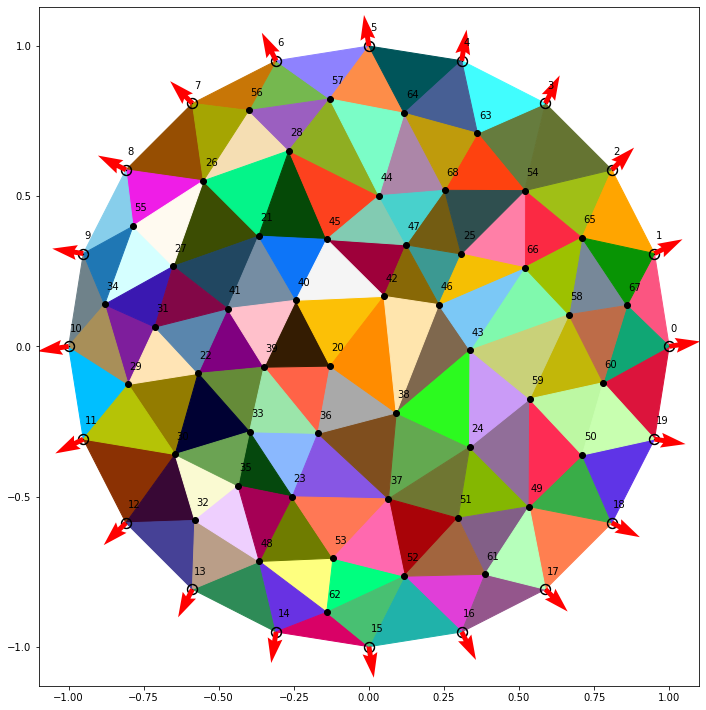

In [55]:
shuffle(all_colors)
colors = all_colors
l = len(colors)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("equal")


for index, triangle in enumerate(triangles_s):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)
#     ax.text(x, y, s=f"{index}", fontsize=10)

for idx, point in enumerate(points):
    pass
    ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=10, color="black")
    
for idx, point in enumerate(points):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color="black", lw=10, s=2)
        ax.quiver(point[0], point[1], boundary_normal[idx,0], boundary_normal[idx,1], color=['r','b','g'], scale=21)
    else:
        ax.scatter(point[0], point[1], color="black")
        
fig.tight_layout()
plt.show()

In [56]:
matrix = np.zeros((6 * points.shape[0], 6 * points.shape[0]), dtype=np.float32)
b = np.zeros(6 * points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
        
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    S2 = (x2-x1)*(y3-y1)-(x3-x1)*(y2-y1)
    
    P_1_x = (+y2 - y3) / S2
    P_2_x = (-y1 + y3) / S2
    
    P_1_y = (-x2 + x3) / S2
    P_2_y = (+x1 - x3) / S2
    
    
    arg = [P_1_x, P_2_x, P_1_y, P_2_y]
    
    delta = (x1 - x3) * (y2 - y3) - (y1 - y3) * (x2 - x3)

    
    # p_1
    if is_boundary_point[element[0]] == True:
        

        matrix[6 * element[0]+0, 6 * element[0]+0] = 1
        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += F[f"{3*i+0}_{3*k+j}_alter"](*arg) * delta
    

        b[6 * element[0]+0] = 0* delta
        b[6 * element[0]+1] += 2 * F["3"] * delta
        b[6 * element[0]+2] += 2 * F["6"] * delta
        b[6 * element[0]+3] += 2 * F["9"] * delta
        b[6 * element[0]+4] += 2 * F["12"]* delta
        b[6 * element[0]+5] += 2 * F["15"]* delta

    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += F[f"{3*i+0}_{3*k+j}_alter"](*arg) * delta
    
        b[6 * element[0]+0] += 2 * F["0"] * delta
        b[6 * element[0]+1] += 2 * F["3"] * delta
        b[6 * element[0]+2] += 2 * F["6"] * delta
        b[6 * element[0]+3] += 2 * F["9"] * delta
        b[6 * element[0]+4] += 2 * F["12"]* delta
        b[6 * element[0]+5] += 2 * F["15"]* delta
        
    if is_boundary_point[element[1]] == True:
    
        matrix[6 * element[1]+0, 6 * element[1]+0] = 1
        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += F[f"{3*i+1}_{3*k+j}_alter"](*arg) * delta
            
        
        b[6 * element[1]+0] = 0* delta
        b[6 * element[1]+1] += 2 * F["4"] * delta
        b[6 * element[1]+2] += 2 * F["7"] * delta
        b[6 * element[1]+3] += 2 * F["10"]* delta
        b[6 * element[1]+4] += 2 * F["13"]* delta
        b[6 * element[1]+5] += 2 * F["16"]* delta

    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += F[f"{3*i+1}_{3*k+j}_alter"](*arg) * delta
    
        b[6 * element[1]+0] += 2 * F["1"] * delta
        b[6 * element[1]+1] += 2 * F["4"] * delta
        b[6 * element[1]+2] += 2 * F["7"] * delta
        b[6 * element[1]+3] += 2 * F["10"]* delta
        b[6 * element[1]+4] += 2 * F["13"]* delta
        b[6 * element[1]+5] += 2 * F["16"]* delta
        
    if is_boundary_point[element[2]] == True:        
        
        matrix[6 * element[2]+0, 6 * element[2]+0] = 1

        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += F[f"{3*i+2}_{3*k+j}_alter"](*arg) * delta
    

        b[6 * element[2]+0] = 0* delta
        b[6 * element[2]+1] += 2 * F["5"] * delta
        b[6 * element[2]+2] += 2 * F["8"] * delta
        b[6 * element[2]+3] += 2 * F["11"]* delta
        b[6 * element[2]+4] += 2 * F["14"]* delta
        b[6 * element[2]+5] += 2 * F["17"]* delta
        
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += F[f"{3*i+2}_{3*k+j}_alter"](*arg) * delta
    
        b[6 * element[2]+0] += 2 * F["2"] * delta
        b[6 * element[2]+1] += 2 * F["5"] * delta
        b[6 * element[2]+2] += 2 * F["8"] * delta
        b[6 * element[2]+3] += 2 * F["11"]* delta
        b[6 * element[2]+4] += 2 * F["14"]* delta
        b[6 * element[2]+5] += 2 * F["17"]* delta

100%|████████████████████████████████████████| 116/116 [00:01<00:00, 107.92it/s]


In [57]:
c = np.linalg.solve(matrix, b)

In [58]:
U = c.reshape(6, -1).sum(axis=0)

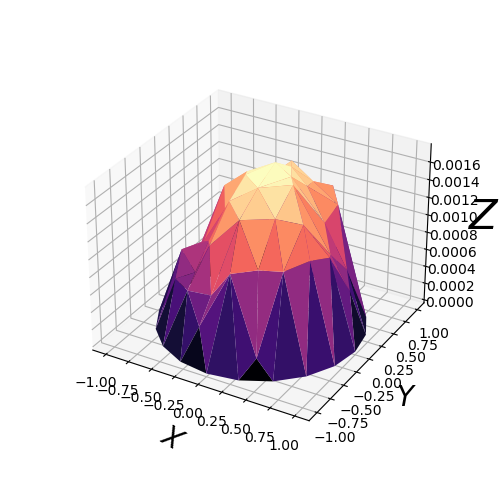

In [59]:
%matplotlib widget
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.set_xlabel('$X$', fontsize=20, rotation=150)
ax.set_ylabel('$Y$', fontsize=20, rotation=0)
ax.set_zlabel('$Z$', fontsize=30, rotation=0)


orig = (1 - points[:, 0]**2 - points[:, 1]**2)**2/64

ax.plot_trisurf(points[:, 0], points[:, 1], c[0::6], cmap="magma")
# ax.plot_trisurf(points[:, 0], points[:, 1], orig, cmap="magma")


plt.show()

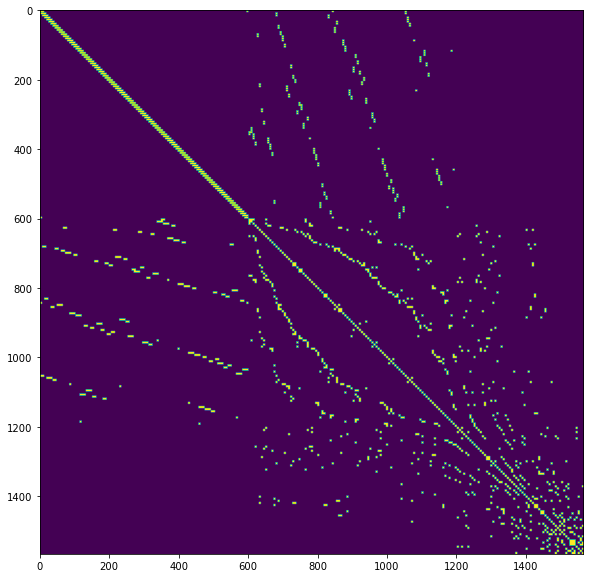

In [28]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(matrix != 0)
plt.show()